# Baixando base dados

In [ ]:
#traning images
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz

#traning labels
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz

#testing images
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz

#testing labels
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

--2023-09-28 16:57:19--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz’

kmnist-train-imgs.n 100%[===================>]  17.53M  1014KB/s    in 16s     

2023-09-28 16:57:35 (1.11 MB/s) - ‘kmnist-train-imgs.npz’ saved [18384171/18384171]

--2023-09-28 16:57:36--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz’

kmnist-train-labels 100%[===================>]  29.00K  --.-KB/s    in 0.1s    

2023-09-28 16:57:36 (197 KB/s) - ‘kmnist-train-labels.npz’ saved [29700/29

# Importando libs

In [ ]:
import argparse, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models, optimizers, losses, metrics, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from  sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm_notebook

# Configurações

In [ ]:
num_classes = 10
input_shape = (28, 28, 1)
LR = 0.001
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1.0e-8
DECAY = 0.0
BATCH_SIZE = 64
NUM_EPOCHS = 50
NUM_CONV_FILTERS = 32
KERNEL_SIZE = (3,3)
POOL_SIZE = (2,2)
VAL_PERC = 0.2

# Carregando Dados

In [ ]:
train_data = np.load('/content/kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('/content/kmnist-train-labels.npz')['arr_0']
test_data = np.load('/content/kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('/content/kmnist-test-labels.npz')['arr_0']

# Explorando a base de Dados

## verificando tamanho e formato dos dados

In [ ]:
print(f'Format of train_datas: {train_data.shape}\n')
print(f'Format of train_labels: {train_labels.shape}\n')
print(f'Format of test_data: {test_data.shape}\n')
print(f'Format of test_labels: {test_labels.shape}\n')
print(f'Min-max values of train_data: {np.min(train_data),np.max(train_data)}\n')

Format of train_datas: (60000, 28, 28)

Format of train_labels: (60000,)

Format of test_data: (10000, 28, 28)

Format of test_labels: (10000,)

Min-max values of train_data: (0, 255)



In [ ]:
def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

<ipython-input-42-06e37876bdfe>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

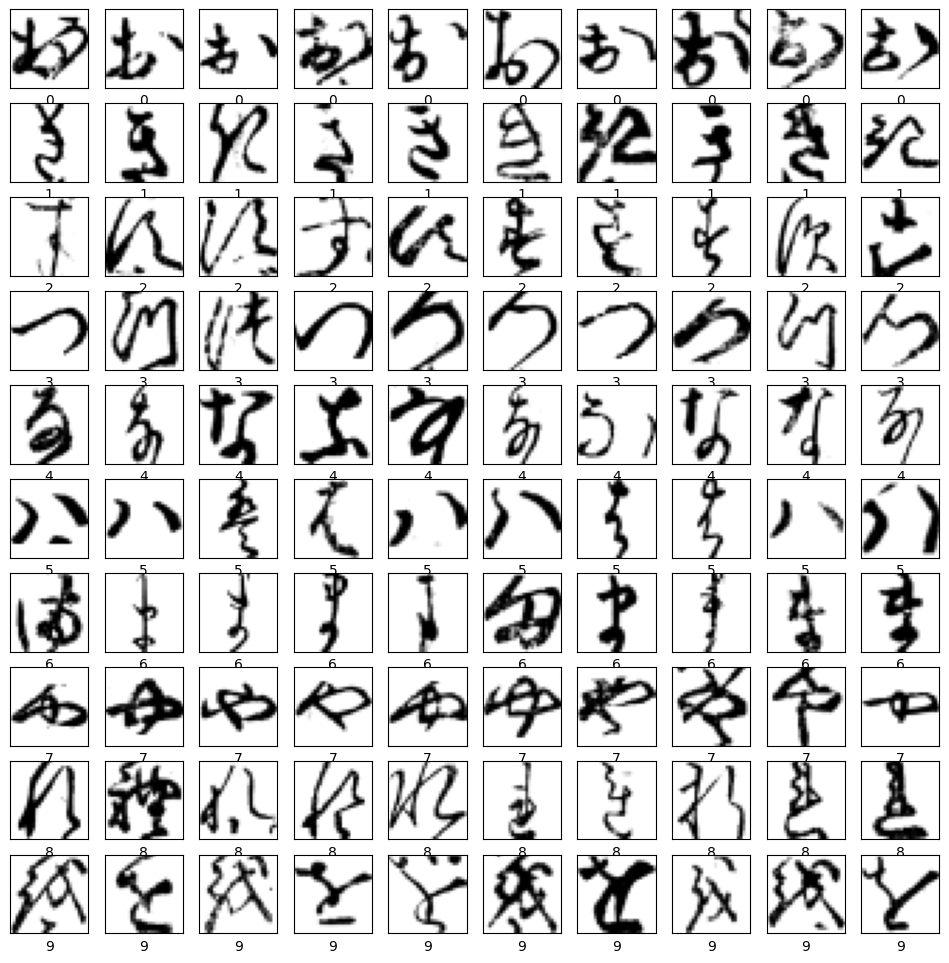

In [ ]:
plot_sample_images_data(train_data, train_labels)

#  Pré-processamento dos dados

## Normalização

In [ ]:
X_train = train_data.astype("float32") / 255
X_test = test_data.astype("float32") / 255

print(f'Min-max values of train_data: {np.min(X_train),np.max(X_train)}\n')
print(f'Min-max values of train_data: {np.min(X_test),np.max(X_test)}\n')

Min-max values of train_data: (0.0, 1.0)

Min-max values of train_data: (0.0, 1.0)



# Reshape

In [ ]:

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Codificando variáveis categóricas utilizando a técnica do one-hot enconding

In [ ]:
train_labels_onehot = keras.utils.to_categorical(train_labels, num_classes)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes)
print("train_labels shape:", train_labels_onehot.shape)
print("test_labels shape:", test_labels_onehot.shape)

train_labels shape: (60000, 10)
test_labels shape: (10000, 10)


## Dividindo dados treino/validação

In [ ]:
nsamples = X_train.shape[0]
nval_samples = int(VAL_PERC * nsamples)

# Dados de validação
X_val = X_train[:nval_samples]
y_val = train_labels_onehot[:nval_samples]

# Dados de treino final
X_train_final = X_train[nval_samples:]
y_train_final = train_labels_onehot[nval_samples:]

print(f'X_train shape: {X_train_final.shape}')
print(f'Y_train shape: {y_train_final.shape}')
print(f'X_val shape {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (48000, 28, 28, 1)
Y_train shape: (48000, 10)
X_val shape (12000, 28, 28, 1)
y_val shape: (12000, 10)


# Construindo modelo

In [ ]:
model = models.Sequential()
model.add(Input(input_shape))
model.add(Conv2D(filters=NUM_CONV_FILTERS, kernel_size=KERNEL_SIZE,strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=POOL_SIZE))
model.add(Conv2D(filters=NUM_CONV_FILTERS*2, kernel_size=KERNEL_SIZE,strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=POOL_SIZE))
model.add(Dropout(0.3))
model.add(Flatten()),
model.add(Dense(NUM_CONV_FILTERS*2, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 3136)             

## definindo otimizador

In [ ]:
opt = optimizers.legacy.Adam(lr=LR,
                      beta_1=BETA1,
                      beta_2=BETA2,
                      epsilon=EPSILON,
                      decay=DECAY)

## compile model

In [ ]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

## early stop

In [ ]:
callbacks_list = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10),
    ]

# Treinamento

In [ ]:
history = model.fit(X_train_final,
                    y_train_final,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/50
750/750 [==============================] - 4s 5ms/step - loss: 0.4356 - accuracy: 0.8647 - val_loss: 0.1577 - val_accuracy: 0.9500
Epoch 2/50
750/750 [==============================] - 3s 5ms/step - loss: 0.1701 - accuracy: 0.9477 - val_loss: 0.0932 - val_accuracy: 0.9718
Epoch 3/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1259 - accuracy: 0.9606 - val_loss: 0.0809 - val_accuracy: 0.9765
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.1003 - accuracy: 0.9683 - val_loss: 0.0653 - val_accuracy: 0.9808
Epoch 5/50
750/750 [==============================] - 3s 5ms/step - loss: 0.0850 - accuracy: 0.9728 - val_loss: 0.0630 - val_accuracy: 0.9800
Epoch 6/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0728 - accuracy: 0.9760 - val_loss: 0.0615 - val_accuracy: 0.9825
Epoch 7/50
750/750 [==============================] - 4s 5ms/step - loss: 0.0646 - accuracy: 0.9784 - val_loss: 0.0626 - val_accuracy: 0.9826
Epoch 

# Avaliando performance do treinamento

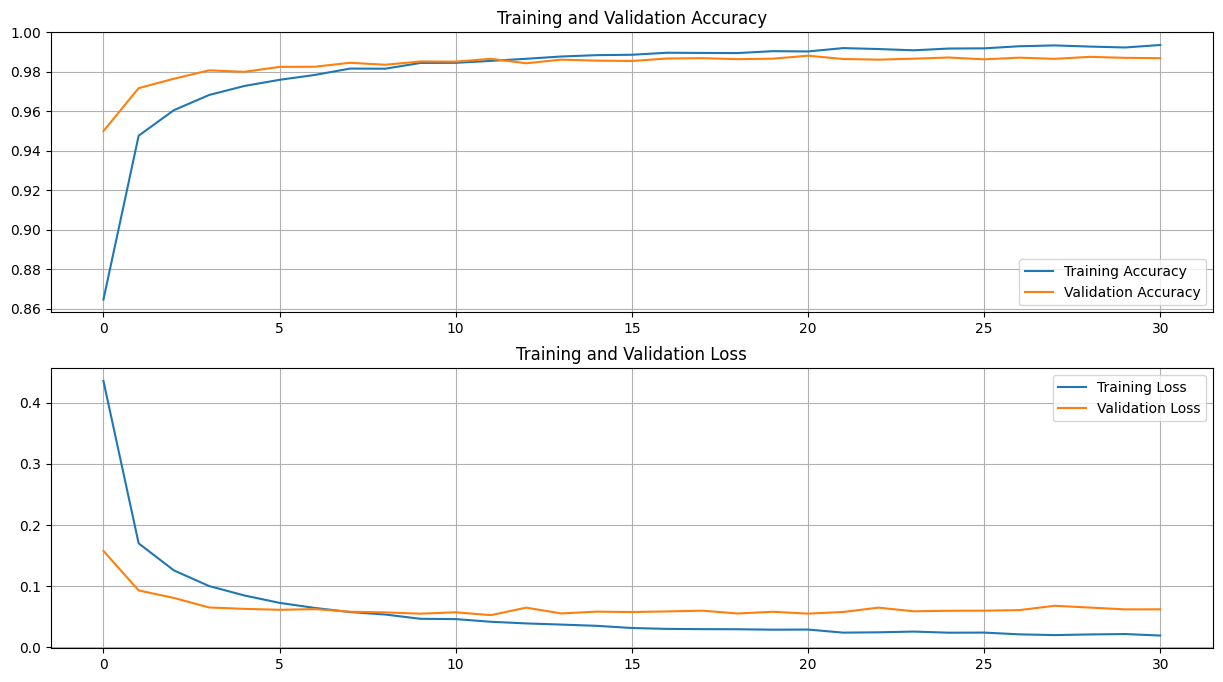

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(31)

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testando o modelo

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax (y_pred, axis = 1)
y_Test = np.argmax (test_labels_onehot, axis = 1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(classification_report(y_Test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1000
           1       0.99      0.94      0.96      1000
           2       0.96      0.90      0.93      1000
           3       0.92      0.99      0.96      1000
           4       0.96      0.94      0.95      1000
           5       0.98      0.95      0.97      1000
           6       0.91      0.99      0.95      1000
           7       0.99      0.95      0.97      1000
           8       0.94      0.98      0.96      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
cm = confusion_matrix(y_Test,y_pred )

<Axes: >

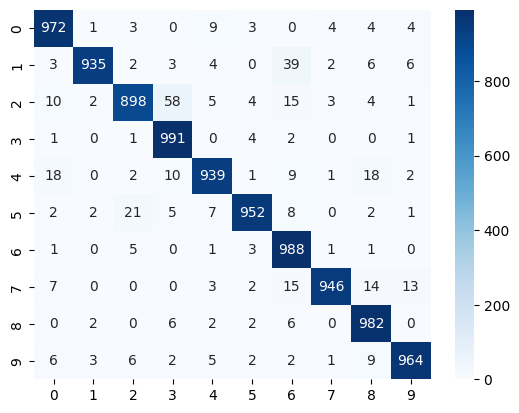

In [ ]:
sns.heatmap(cm, annot=True,fmt='.0f', cmap='Blues' )